In [1]:
import tensorflow as tf
import art
import warnings

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# tf.compat.v1.disable_eager_execution()
print(f'Tensorflow version {tf.__version__}')
print(f'ART Version {art.__version__}')
import sys
sys.path.append('../lib')
import utils
from utils import load_preprocess, show_adversarial_images

from art.attacks.evasion import AdversarialPatchNumpy
# from art.estimators.classification import KerasClassifier
import tensorflow as tf


2024-06-10 14:36:09.442265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 14:36:09.442297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 14:36:09.443374: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.15.1
ART Version 1.17.1


In [2]:
# Load a pre-trained model
model = ResNet50V2(weights='imagenet')
# Wrap the model with ART's classifier
# classifier = KerasClassifier(model=model, clip_values=(0, 1))


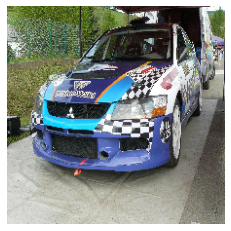

In [3]:
img = load_preprocess('../images/racing-car.jpg', show=True) 


In [4]:
def generate_adversarial_patch(target_shape=(224, 224, 3)):
    patch = np.random.uniform(0, 255, size=target_shape).astype(np.float32)
    patch = preprocess_input(np.expand_dims(patch, axis=0))
    return patch
# Apply the patch to the image
def apply_patch_to_image(img, patch, patch_location=(50, 50)):
    patched_img = img.copy()
    patch_size = patch.shape[1:3]
    patched_img[0, patch_location[0]:patch_location[0]+patch_size[0], patch_location[1]:patch_location[1]+patch_size[1], :] = patch[0]
    return patched_img


In [5]:
# Generate and apply the adversarial patch
patch = generate_adversarial_patch((50, 50, 3))  # Smaller patch for demonstration
patched_img = apply_patch_to_image(img, patch)

In [6]:
# Classify the original and patched images
def classify_image(img):
    preds = model.predict(img)
    return decode_predictions(preds, top=3)[0]

# Classify and display the results
original_preds = classify_image(img)
patched_preds = classify_image(patched_img)

print("Original Image Predictions:")
for pred in original_preds:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")

print("\nPatched Image Predictions:")
for pred in patched_preds:
    print(f"{pred[1]}: {pred[2]*100:.2f}%")

1/1 [==============================] - 0s 15ms/step
Original Image Predictions:
racer: 64.21%
sports_car: 23.06%
grille: 4.53%

Patched Image Predictions:
grille: 43.81%
racer: 29.96%
sports_car: 13.33%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


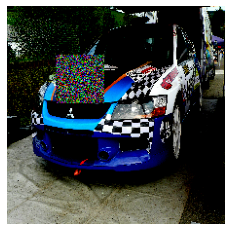

In [7]:
utils.show_image(patched_img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


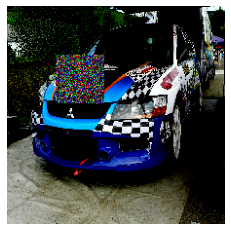

In [23]:

def generate_targeted_adversarial_patch(model, target_class, target_shape=(50, 50, 3), steps=1000, learning_rate=0.01):
    # Create a TensorFlow variable for the patch
    patch = tf.Variable(np.random.uniform(0, 255, size=(1,) + target_shape).astype(np.float32))
    patch.assign(patch / 127.5 - 1.0)

    # Define the target class label
    target = tf.one_hot(target_class, 1000)
    target = tf.reshape(target, (1, 1000))

    # Define the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for _ in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(patch)
            patched_img = apply_patch_to_image(img, patch)
            predictions = model(patched_img)
            loss = tf.keras.losses.categorical_crossentropy(target, predictions)
        
        # Compute gradients of the loss with respect to the patch
        gradients = tape.gradient(loss, patch)
        
        if gradients is not None:
            # Manually apply gradients to the patch
            patch.assign_sub(learning_rate * gradients)
    
    return patch.numpy()
# Generate and apply the adversarial patch
patch = generate_targeted_adversarial_patch(model, target_class, (50, 50, 3))
patched_img = apply_patch_to_image(img, patch)
utils.show_image(patched_img[0])

In [20]:
# Classify and display the results
original_preds = classify_image(img)
patched_preds = classify_image(patched_img)

1/1 [==============================] - 0s 15ms/step


In [21]:
patched_preds

[('n03459775', 'grille', 0.47373545),
 ('n04037443', 'racer', 0.30558935),
 ('n04285008', 'sports_car', 0.1474428)]

In [22]:
original_preds

[('n04037443', 'racer', 0.64211035),
 ('n04285008', 'sports_car', 0.23064095),
 ('n03459775', 'grille', 0.045331467)]